<a href="https://colab.research.google.com/github/ThisIsXinyuHuo/w2ot/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms
print("Running on torch.__version__ = ", torch.__version__)

torch.backends.cudnn.deterministic = True

# utils
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

Running on torch.__version__ =  2.1.0+cu118


In [ ]:
%matplotlib inline

import subprocess
import numpy as np
import matplotlib.cm as cm
from datetime import datetime
plt.style.use('ggplot')

from pylab import rcParams
rcParams['figure.figsize'] = (10, 6)

import matplotlib
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 17}
matplotlib.rc('font', **font)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd gdrive/My Drive/project/

/content/gdrive/My Drive/project


In [ ]:
# functions to read data and meta data
def read_data_given_id(path,ids,progress=True,last_offset=0):
    '''read data given a list of ids and CSV paths'''
    start = datetime.now()
    n = len(ids)
    if n == 0:
        return {}
    else:
        data = {}
        for (i,ist_id) in enumerate(ids, start=1):
            if progress and np.mod(i,np.ceil(n/10))==0:
                print('%d/%d (%2.0f%s) have been read...\t time consumed: %ds'\
                      %(i,n,i/n*100,'%',(datetime.now()-start).seconds))
            if last_offset==0:
                data[ist_id] = np.genfromtxt(path+str(ist_id)+'.csv',delimiter=',',\
                                         names='current,voltage',dtype=(float,float))
            else:
                p=subprocess.Popen(['tail','-'+str(int(last_offset)),path+str(ist_id)+'.csv'],\
                                   stdout=subprocess.PIPE)
                data[ist_id] = np.genfromtxt(p.stdout,delimiter=',',names='current,voltage',dtype=(float,float))
        print('%d/%d (%2.0f%s) have been read(Done!) \t time consumed: %ds'\
            %(n,n,100,'%',(datetime.now()-start).seconds))
        return data


def clean_meta(ist):
    '''remove None elements in Meta Data '''
    clean_ist = ist.copy()
    for k,v in ist.items():
        if len(v) == 0:
            del clean_ist[k]
    return clean_ist

def parse_meta(meta):
    '''parse meta data for easy access'''
    M = {}
    for m in meta:
        for app in m:
            M[int(app['id'])] = clean_meta(app['meta'])
    return M

In [ ]:
# specify path to read data and meta
# Please make sure you downloaded latest dataset from plaidplug.com.
Data_path = 'data/'
csv_path = Data_path + 'CSV/';

import json

# read meta
with open(Data_path + 'meta1.json') as data_file:
    meta1 = json.load(data_file)


Meta = parse_meta([meta1])
meta1 = parse_meta([meta1])

In [ ]:
# read data
# applinace types of all instances
Types = [x["appliance"]['type'] for x in Meta.values()]
# unique appliance types
Unq_type = list(set(Types))
Unq_type.sort()
IDs_for_read_data = list(Meta.keys())
# households of appliances
Locs = [x['header']['collection_time']+'_'+x['location'] for x in Meta.values()]
# unique households
Unq_loc = list(set(Locs))
Unq_loc.sort()
Origianl_Unq_type = Unq_type

In [ ]:
print('Number of households: %d\nNumber of total measurements:%d'%(len(Unq_loc),len(Locs)))

Number of households: 64
Number of total measurements:1793


In [ ]:
# read data
# estimated time cost:  ~ 1 mins
npts = 10000
Data = read_data_given_id(csv_path,IDs_for_read_data,progress=True, last_offset=npts)

180/1793 (10%) have been read...	 time consumed: 482s
360/1793 (20%) have been read...	 time consumed: 1049s
540/1793 (30%) have been read...	 time consumed: 1627s
720/1793 (40%) have been read...	 time consumed: 2176s
900/1793 (50%) have been read...	 time consumed: 2723s
1080/1793 (60%) have been read...	 time consumed: 3264s
1260/1793 (70%) have been read...	 time consumed: 3875s
1440/1793 (80%) have been read...	 time consumed: 4446s
1620/1793 (90%) have been read...	 time consumed: 5073s
1793/1793 (100%) have been read(Done!) 	 time consumed: 5674s


In [ ]:
print('Total number of instances:%d'%len(Data))

Total number of instances:1793


In [ ]:
fs = 30000
f0 = 60
NS = fs//f0 # number of samples per period
NP = npts//NS # number of periods for npts

# calculate the representative one period of steady state
# (mean of the aggregated signals over one cycle)
n = len(Data)
rep_I = np.empty([n,NS])
rep_V = np.empty([n,NS])
for i in range(n):
    tempI = np.sum(np.reshape(Data[i+1]['current'],[NP,NS]),0)/NP
    tempV = np.sum(np.reshape(Data[i+1]['voltage'],[NP,NS]),0)/NP
    # align current to make all samples start from 0 and goes up
    ix = np.argsort(np.abs(tempI))
    j = 0
    while True:
        if ix[j]<499 and tempI[ix[j]+1]>tempI[ix[j]]:
            real_ix = ix[j]
            break
        else:
            j += 1
    rep_I[i,] = np.hstack([tempI[real_ix:],tempI[:real_ix]])
    rep_V[i,] = np.hstack([tempV[real_ix:],tempV[:real_ix]])

In [ ]:
type_Ids = {}
loc_Ids = {}
n = len(Data)
type_label = np.zeros(n,dtype='int')
loc_label = np.zeros(n,dtype='int')
for (ii,t) in enumerate(Unq_type):
    type_Ids[t] = [i-1 for i,j in enumerate(Types,start=1) if j == t]
    type_label[type_Ids[t]] = ii+1
for (ii,t) in enumerate(Unq_loc):
    loc_Ids[t] = [i-1 for i,j in enumerate(Locs,start=1) if j == t]
    loc_label[loc_Ids[t]] = ii+1
print('number of different types: %d'% len(Unq_type))
print('number of different households: %d'% len(Unq_loc))

number of different types: 11
number of different households: 64


['Air Conditioner', 'Compact Fluorescent Lamp', 'Fan', 'Fridge', 'Hairdryer', 'Heater', 'Incandescent Light Bulb', 'Laptop', 'Microwave', 'Vacuum', 'Washing Machine']
Similified verstion:
['AC', 'CFL', 'Fan', 'Fridge', 'Hairdryer', 'Heater', 'Bulb', 'Laptop', 'Microwave', 'Vacuum', 'Washer']


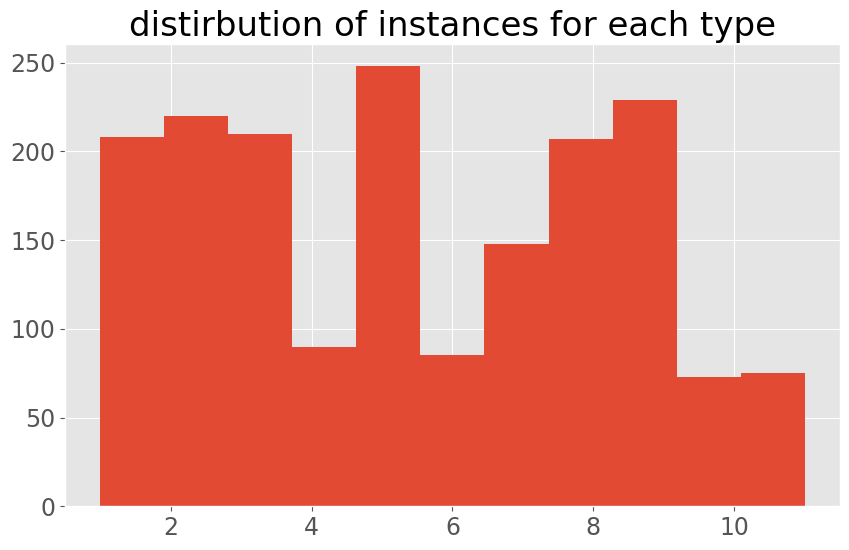

In [ ]:
plt.hist(type_label,len(Unq_type))
plt.title('distirbution of instances for each type')
print(Origianl_Unq_type)
print('Similified verstion:')
Unq_type[0]='AC';
Unq_type[1]='CFL';
Unq_type[6]='Bulb';
Unq_type[10]='Washer';
print(Unq_type)
plt.savefig('type_dist.eps', format='eps')

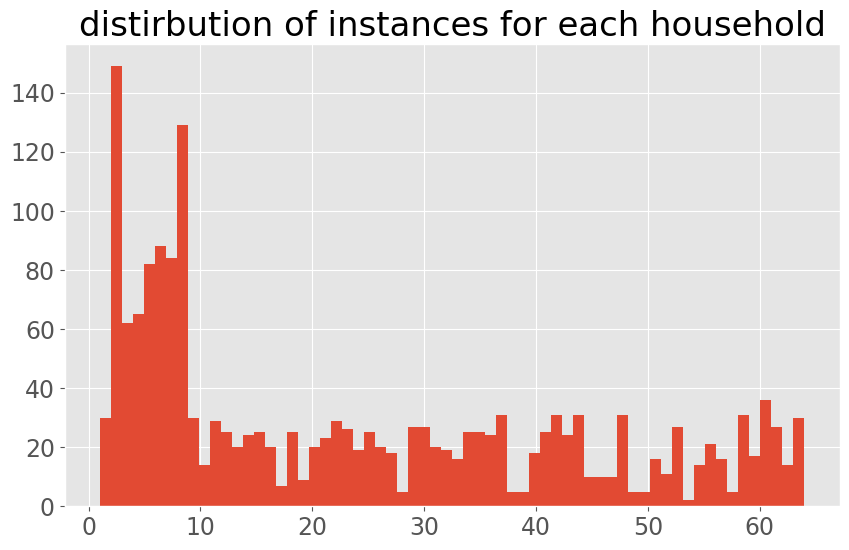

In [ ]:
plt.hist(loc_label,len(Unq_loc))
plt.title('distirbution of instances for each household')
plt.savefig('house_dist.eps', format='eps')

In [ ]:
def center(X,w):
    minX = np.amin(X)
    maxX = np.amax(X)
    dist = max(abs(minX),maxX)
    X[X<-dist] = -dist
    X[X>dist] = dist
    d = (maxX-minX)/w
    return (X,d)

def get_img_from_VI(V, I, width,hard_threshold=False,para=.5):
    '''Get images from VI, hard_threshold, set para as threshold to cut off,5-10
    soft_threshold, set para to .1-.5 to shrink the intensity'''

    d = V.shape[0]
    # doing interploation if number of points is less than width*2
    if d<2* width:
        newI = np.hstack([V, V[0]])
        newV = np.hstack([I, I[0]])
        oldt = np.linspace(0,d,d+1)
        newt = np.linspace(0,d,2*width)
        I = np.interp(newt,oldt,newI)
        V = np.interp(newt,oldt,newV)
    # center the current and voltage, get the size resolution of mesh given width
    (I,d_c)  = center(I,width)
    (V,d_v)  = center(V,width)

    #  find the index where the VI goes through in current-voltage axis
    ind_c = np.floor((I-np.amin(I))/d_c).astype(int)
    ind_v = np.floor((V-np.amin(V))/d_v).astype(int)
    ind_c[ind_c==width] = width-1
    ind_v[ind_v==width] = width-1

    Img = np.zeros((width,width))

    for i in range(len(I)):
        Img[ind_c[i],width-ind_v[i]-1] += 1

    if hard_threshold:
        Img[Img<para] = 0
        Img[Img!=0] = 1
        return Img
    else:
        return (Img/np.max(Img))**para

In [ ]:
n = len(Data)
width = 16

Imgs = np.zeros((n,width,width), dtype=np.float64)
for i in range(n):
    Imgs[i,:,:] = get_img_from_VI(rep_V[i,], rep_I[i,], width,True,1)
BinaryF=np.reshape(Imgs,(n,width*width))

In [ ]:
i

1792

In [ ]:
np.array([Imgs[13,:,:]]).shape

(1, 16, 16)

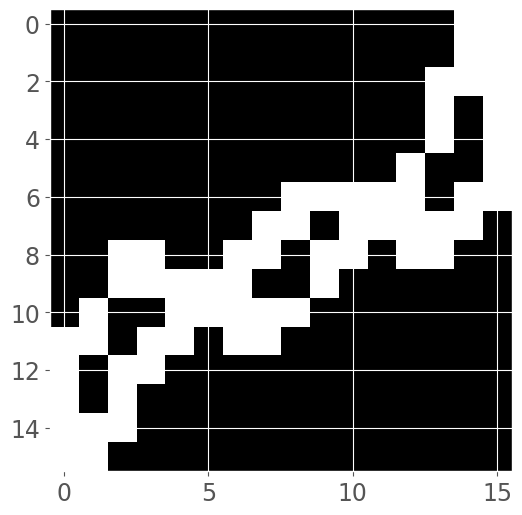

In [ ]:
 plt.imshow(Imgs[13,:,:],cmap = cm.Greys_r,interpolation='None')

In [ ]:
Imgs2 = [[x] for x in Imgs]
np.array(Imgs2).shape

(1793, 1, 16, 16)

In [ ]:
Imgs[:split_id].shape

NameError: ignored

In [ ]:
np.unique(type_label -1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [ ]:
# we use 70%, 15%, 15% for train, validation, and test sets
train_size = .7
val_size = .5
labels = type_label - 1

# make train set
split_id = int(len(Imgs2) * train_size)
train_x, remain_x = np.float32(Imgs2[:split_id]), np.float32(Imgs2[split_id:])
train_y, remain_y = np.intc(labels[:split_id]), np.intc(labels[split_id:])

# make val and test set
split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

# print out the shape
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

Train set: (1255, 1, 16, 16)
Validation set: (269, 1, 16, 16)
Test set: (269, 1, 16, 16)


In [ ]:
type(train_y)

numpy.ndarray

In [ ]:
train_y

array([ 1,  1,  1, ..., 10,  1,  1], dtype=int32)

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, imgs, labels):
        self.data = torch.utils.data.TensorDataset(torch.from_numpy(imgs), torch.from_numpy(labels).long())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index][0]
        label = self.data[index][1]

        return {'img': img, 'label': label}


train_set = MyDataset(train_x, train_y)
val_set = MyDataset(val_x, val_y)
test_set = MyDataset(test_x, test_y)

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=128)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=True, batch_size=128)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=128)

In [ ]:
dataiter = iter(train_loader)
x = next(dataiter)

x['img'].shape

torch.Size([128, 1, 16, 16])

In [ ]:
(128x6272 and 21632x10)
(128x6272 and 21632x10)

Running on torch.__version__ =  2.1.0+cu118


In [ ]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.fc = nn.Linear(6272, 11)



    def forward(self, input_dict):
        x = self.conv1(input_dict['img'])
        print(1)
        x = self.relu1(x)
        print(2)
        x = self.pool1(x)
        print(3)
        x = self.conv2(x)
        print(4)
        x = self.relu2(x)
        print(5)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        print(6)
        x = self.fc(x)
        pred_label = nn.functional.log_softmax(x, dim=1)

        return {'label': pred_label}

In [ ]:
network = MyNetwork()
print(network)

MyNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=6272, out_features=11, bias=True)
)


In [ ]:
# a function to move tensors from the CPU to the GPU and vice versa
def dict_to_device(orig, device):
    new = {}
    for k,v in orig.items():
        new[k] = v.to(device)
    return new

# a function to make gray-scale images the same shape as color images
def gray_to_color(x):
    return x.repeat(3, 1, 1)

# a function to plot a batch of images together
def plot_images(img, ax):
    img = torchvision.utils.make_grid(img)
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
CUDA_LAUNCH_BLOCKING="1"

In [ ]:
# training loop
%matplotlib inline
from IPython import display

# prepare plotting
fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,3)

optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

num_epochs = 5
train_losses = []
val_losses = []

for e in range(num_epochs):
    train_iter = iter(train_loader)
    network.train()
    for i in range(len(train_loader)):
        batch_cpu = next(train_iter)
        #batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_cpu)
        #pred_cpu = dict_to_device(pred, 'cpu')

        # calculate the loss and backward the gradient
        print(batch_cpu['label'].dtype)
        loss = nn.CrossEntropyLoss()(pred['label'], batch_cpu['label'].long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if i%100==0:
            axes[0].cla()
            axes[1].cla()

            # plot some sample image inputs
            plot_images(batch_cpu['image'][0:1], ax=axes[0])
            axes[0].legend()
            axes[0].set_title('sample input')

            # plot the training error on a log plot
            axes[1].plot(train_losses, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Training loss')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Training epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(train_loader), 100*i//len(train_loader), train_losses[-1]))

    val_iter = iter(val_loader)
    network.eval()
    for i in range(len(val_loader)):
        batch_cpu = next(val_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')

        # calculate the loss
        with torch.no_grad():
            loss = nn.CrossEntropyLoss()(pred['label'], batch_gpu['label'])
            val_losses.append(loss.item())

        if i%10==0:
            axes[2].cla()

            # plot the validation error on a log plot
            axes[2].plot(val_losses, label='loss')
            axes[2].set_yscale('log')
            axes[2].set_title('Validation loss')
            axes[2].set_xlabel('number of gradient iterations')
            axes[2].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Validation epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(val_loader), 100*i//len(val_loader), val_losses[-1]))
plt.close('all')

NameError: ignored

In [ ]:
n = sum(type_label==type_id)
n

208

1

In [ ]:
np.where(type_label==1)[0]

array([  14,   15,   16,   37,   38,   39,   82,   83,   84,   85,   86,
        159,  160,  161,  162,  163,  287,  288,  289,  290,  291,  364,
        365,  366,  367,  373,  374,  375,  376,  377,  393,  394,  395,
        396,  397,  422,  423,  424,  425,  426,  427,  448,  449,  450,
        451,  452,  512,  513,  514,  515,  516,  783,  784,  785,  786,
        787,  984,  985,  986,  987,  988, 1005, 1006, 1007, 1008, 1009,
       1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114,
       1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125,
       1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136,
       1137, 1138, 1139, 1140, 1141, 1142, 1143, 1315, 1316, 1317, 1318,
       1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329,
       1330, 1331, 1332, 1333, 1334, 1462, 1463, 1464, 1465, 1466, 1467,
       1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478,
       1479, 1480, 1550, 1551, 1552, 1553, 1554, 15

In [ ]:
# visualization of all imgaes from certain type in Imgs
type_id = 1
n = sum(type_label==type_id)
fig = plt.figure(figsize=(14,np.ceil(int(n//15))))
count = 1
for i in np.where(type_label==type_id)[0]:
    plt.subplot(np.ceil(int(n//10)),15,count)
    plt.imshow(Imgs[i,:,:],cmap = cm.Greys_r,interpolation='None')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
#     plt.title('Id: '+str(k),fontsize=10)
    count += 1
fig.tight_layout()
plt.show()

ValueError: ignored

<Figure size 1400x1300 with 0 Axes>

In [ ]:
n / 10

20.8